In [4]:
from src import dataloader
from src.constants import constants
from src.dataloader import labelEncoding, labelDecoding
from models.cGAN_300_300 import cGAN
from models.callbacks import LoggingCheckpointTraining, SaveImageTraining

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Dropout, Input, Concatenate, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
get_data = dataloader.DataLoader(
    data_dir=f"{constants.data.FINAL_PATH}/groundtruth.csv",
    aps_list=constants.aps, batch_size=30, step_size=5,
    size_reference_point_map=28, return_axis_coords=False
)
X, y, _ = get_data()
minimo, maximo = np.min(X), np.max(X)
X_reescalado = 2 * (X - minimo) / (maximo - minimo) - 1
y_encoded = labelEncoding(y)

In [34]:
def define_discriminator(input_shape=(28,28,1), n_classes=7):
    input_label = Input(shape=(1,), name="input_label")
    lab = Embedding(n_classes, 50)(input_label)
    lab = Dense(input_shape[0]*input_shape[1]*1)(lab)
    lab = Reshape((input_shape[0], input_shape[1], 1))(lab)

    input_image = Input(shape=input_shape, name="input_image")
    combined = Concatenate(name="concatenate")([input_image, lab])

    x = Conv2D(64, (3,3), strides=(2,2), padding="same")(combined)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (3,3), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (3,3), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)


    x = Flatten()(x)
    out = Dense(1, activation="sigmoid", name="out_layer")(x)

    model = Model([input_image, input_label], out, name="discriminator")
    return model

def define_generator(latent_dim=100, n_classes=7):
    input_label = Input(shape=(1,), name="input_label")
    lab = Embedding(n_classes, 50)(input_label)
    lab = Dense(7*7*128)(lab)
    lab = Reshape((7, 7, 128))(lab)

    input_latent = Input(shape=(latent_dim,), name="input_noise")
    x = Dense(7*7*128)(input_latent)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 128))(x)

    combined = Concatenate(name="concatenate")([x, lab])

    x = Conv2DTranspose(128, (3,3), strides=(2,2), padding="same")(combined)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64, (5,5), strides=(2,2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64, (7,7), strides=(1,1), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    out = Conv2D(1, (1,1), activation="tanh", padding="same")(x)

    model = Model([input_latent, input_label], out, name="generator")
    return model

discriminator = define_discriminator()
generator = define_generator(latent_dim=100)

tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_activations=True)

path_cgan_28 = "outputs/process_training/cGAN_28_28"
path_cgan_28_checkpoints = f"{path_cgan_28}/checkpoints"
path_cgan_28_images = f"{path_cgan_28}/images"
path_cgan_28_learning_curves = f"{path_cgan_28}/learning_curves"

os.makedirs(path_cgan_28, exist_ok=True)
os.makedirs(path_cgan_28_checkpoints, exist_ok=True)
os.makedirs(path_cgan_28_images, exist_ok=True)
os.makedirs(path_cgan_28_learning_curves, exist_ok=True)


# define the training dataset
dataset = tf.data.Dataset.from_tensor_slices((X_reescalado, y_encoded)).shuffle(1000).batch(64)

# define callbacks
save_image = SaveImageTraining(X_reescalado, y_encoded, save_dir=path_cgan_28_images)
save_model = LoggingCheckpointTraining(save_dir=path_cgan_28_checkpoints)
hist = History()
decay_lr = ReduceLROnPlateau(monitor='loss_g', factor=0.9, patience=5, verbose=1, min_lr=0.00001)

callbacks = [
    save_image,
    save_model,
    hist,
    decay_lr
]

#  modelo cGAN
cgan = cGAN(generator, discriminator)

#  compile model
cgan.compile(
    Adam(learning_rate=0.001, beta_1=0.5),
    Adam(learning_rate=0.001, beta_1=0.5),
    tf.keras.losses.BinaryCrossentropy(),
    tf.keras.losses.BinaryCrossentropy()
)

# train model
cgan.fit(dataset, epochs=500, callbacks=callbacks)

# Curvas de aprendizaje
plt.plot(hist.history["loss_d"], label="loss_d")
plt.plot(hist.history["loss_g"], label="loss_g")
plt.title("Curvas de aprendizaje")
plt.legend()
plt.savefig(f"{path_cgan_28_learning_curves}/learning_curves.png")
plt.close()


Epoch 1/500
25/25 [==============================] - 3s 84ms/step - loss_d: 0.6404 - loss_g: 1.0304 - lr: 0.0010
Epoch 2/500
25/25 [==============================] - 2s 80ms/step - loss_d: 0.6793 - loss_g: 0.8996 - lr: 0.0010
Epoch 3/500
25/25 [==============================] - 2s 79ms/step - loss_d: 0.6438 - loss_g: 1.0053 - lr: 0.0010
Epoch 4/500
25/25 [==============================] - 2s 80ms/step - loss_d: 0.7269 - loss_g: 0.9130 - lr: 0.0010
Epoch 5/500
25/25 [==============================] - 2s 80ms/step - loss_d: 0.6892 - loss_g: 0.7323 - lr: 0.0010
Epoch 6/500
25/25 [==============================] - 3s 138ms/step - loss_d: 0.6809 - loss_g: 0.7367 - lr: 0.0010
Epoch 7/500
25/25 [==============================] - 2s 89ms/step - loss_d: 0.6758 - loss_g: 0.7878 - lr: 0.0010
Epoch 8/500
25/25 [==============================] - 2s 80ms/step - loss_d: 0.6853 - loss_g: 0.7922 - lr: 0.0010
Epoch 9/500
25/25 [==============================] - 2s 81ms/step - loss_d: 0.6888 - loss_g: 0.

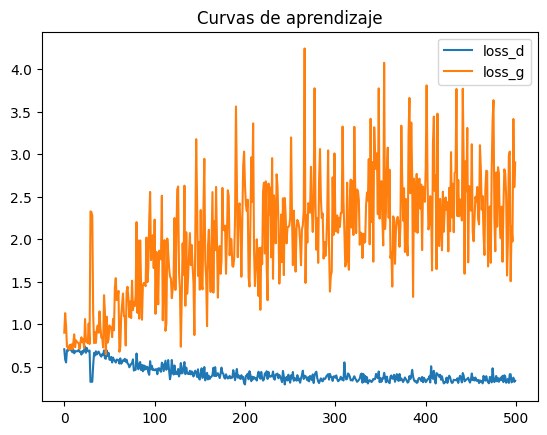

In [39]:
plt.plot(hist.history["loss_d"], label="loss_d")
plt.plot(hist.history["loss_g"], label="loss_g")
plt.title("Curvas de aprendizaje")
plt.legend()
plt.show()